## Matrix Profile Quickstart with Stumpy

In [1]:
import pandas as pd
import numpy as np
import stumpy
import numpy.testing as npt
import time
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

In [18]:
import seaborn as sns
import streamlit as st
import pandas as pd
import json
import requests
from streamlit_autorefresh import st_autorefresh
from requests_kerberos import HTTPKerberosAuth, OPTIONAL
import os

In [262]:
a = os.environ["SSB_MV"].replace("gateway", "manager0").split("/")
ssb_endpoint = "https://"+a[2]+":18131/api/v1/query/"+a[-2]+"/"+a[-1] 

def load_data(endpoint):
    r = requests.get(endpoint, auth=HTTPKerberosAuth(mutual_authentication=OPTIONAL))
    data = pd.DataFrame(json.loads(r.text))
    data[['duration','waiting']] = data[['duration','waiting']].astype('int')
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    #data = data[:100]
    return data

geyser = load_data(ssb_endpoint)

### Batch Matrix Profile

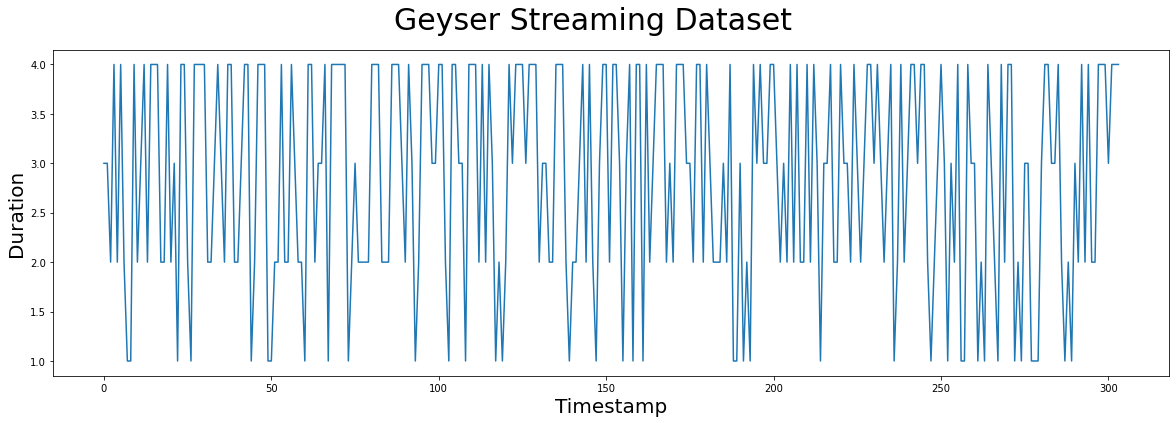

In [89]:
plt.suptitle('Geyser Streaming Dataset', fontsize='30')
plt.xlabel('Timestamp', fontsize ='20')
plt.ylabel('Duration', fontsize='20')
plt.plot(geyser['duration'].values)
plt.show()

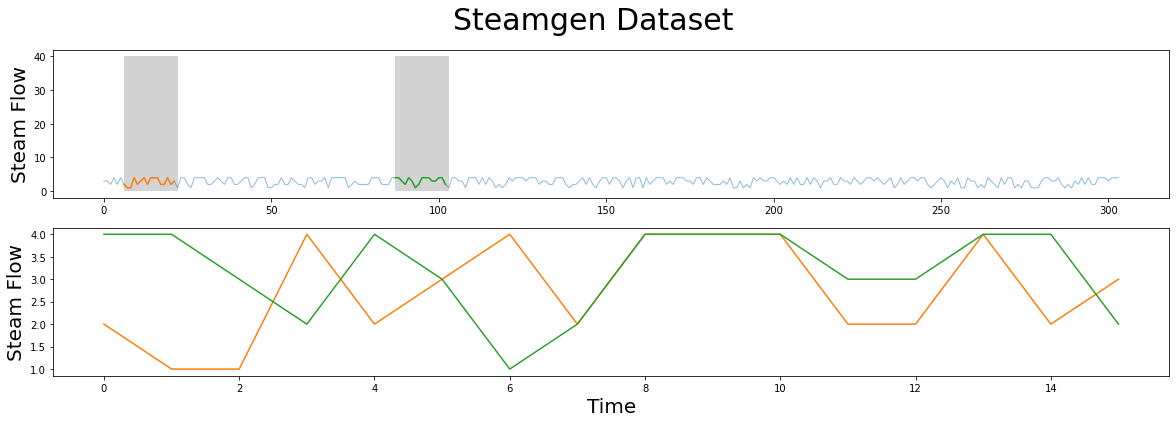

In [88]:
m = 16
fig, axs = plt.subplots(2)
plt.suptitle('Steamgen Dataset', fontsize='30')
axs[0].set_ylabel("Steam Flow", fontsize='20')
axs[0].plot(geyser['duration'], alpha=0.5, linewidth=1)
axs[0].plot(geyser['duration'].iloc[6:6+m])
axs[0].plot(geyser['duration'].iloc[87:87+m])
rect = Rectangle((6, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((87, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel("Time", fontsize='20')
axs[1].set_ylabel("Steam Flow", fontsize='20')
axs[1].plot(geyser['duration'].values[6:6+m], color='C1')
axs[1].plot(geyser['duration'].values[87:87+m], color='C2')
plt.show()

### Finding Anomalies with Batch Data

In [91]:
m = 16
mp = stumpy.stump(geyser['duration'].astype(np.float64), m)

In [92]:
motif_idx = np.argsort(mp[:, 0])[0]

print(f"The motif is located at index {motif_idx}")

The motif is located at index 260


In [93]:
nearest_neighbor_idx = mp[motif_idx, 1]

print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

The nearest neighbor is located at index 19


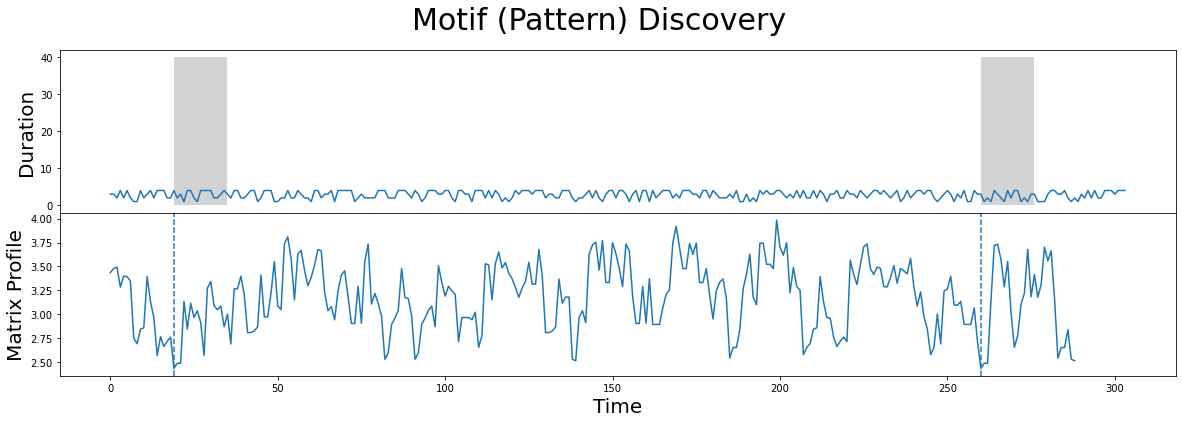

In [94]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(geyser['duration'].astype(np.float64).values)
axs[0].set_ylabel('Duration', fontsize='20')
rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

What we learn is that the global minima (vertical dashed lines) from the matrix profile correspond to the locations of the two subsequences that make up the motif pair! And the exact z-normalized Euclidean distance between these two subsequences is:

In [95]:
mp[motif_idx, 0]

2.432528807474868

Conversely, the index location within our matrix profile that has the largest value (computed from stump above) is:

In [96]:
discord_idx = np.argsort(mp[:, 0])[-1]

print(f"The discord is located at index {discord_idx}")

The discord is located at index 199


And the nearest neighbor to this discord has a distance that is quite far away:

In [97]:
nearest_neighbor_distance = mp[discord_idx, 0]

print(f"The nearest neighbor subsequence to this discord is {nearest_neighbor_distance} units away")

The nearest neighbor subsequence to this discord is 3.9841581065857534 units away


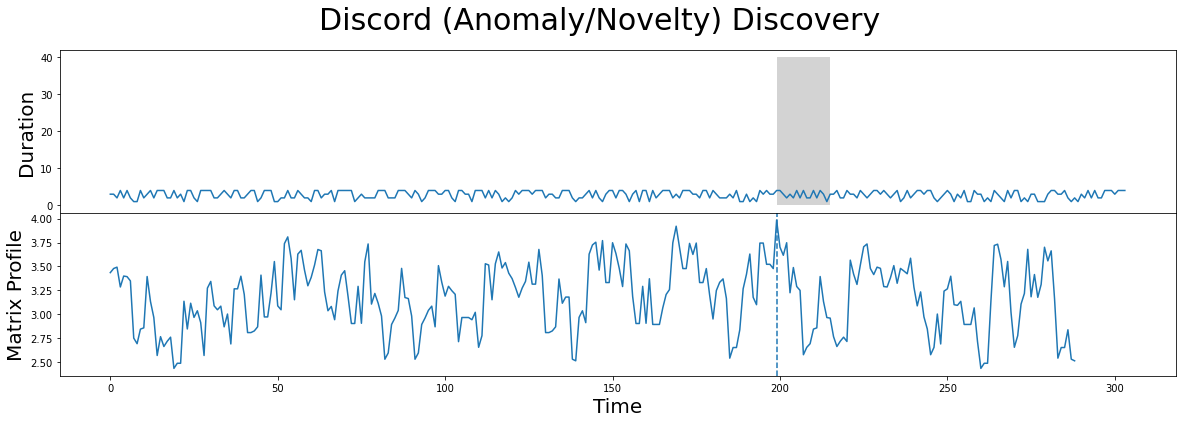

In [98]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Discord (Anomaly/Novelty) Discovery', fontsize='30')

axs[0].plot(geyser['duration'].astype(np.float64).values)
axs[0].set_ylabel('Duration', fontsize='20')
rect = Rectangle((discord_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=discord_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

## Fast Pattern Matching

In [253]:
T_df = geyser['waiting']
T_df.head()

0    56
1    40
2    62
3    60
4    44
Name: waiting, dtype: int64

In [254]:
Q_df = pd.Series([12,39,45,1,9,140])

In [255]:
print("The pattern we want to find:")
Q_df

The pattern we want to find:


0     12
1     39
2     45
3      1
4      9
5    140
dtype: int64

In [256]:
distance_profile = stumpy.mass(Q_df.astype(np.float64), T_df.astype(np.float64))

In [257]:
print("Total Dataset Shape:", T_df.shape)
print("Query Shape:", Q_df.shape)

Total Dataset Shape: (304,)
Query Shape: (6,)


In [258]:
idx = np.argmin(distance_profile)

print(f"The nearest neighbor to `Q_df` is located at index {idx} in `T_df`")

The nearest neighbor to `Q_df` is located at index 165 in `T_df`


In [259]:
Q_z_norm = stumpy.core.z_norm(Q_df.values)
nn_z_norm = stumpy.core.z_norm(T_df.values[idx:idx+len(Q_df)])

The nearest neighbor to `Q_df` is located at index 165 in `T_df`


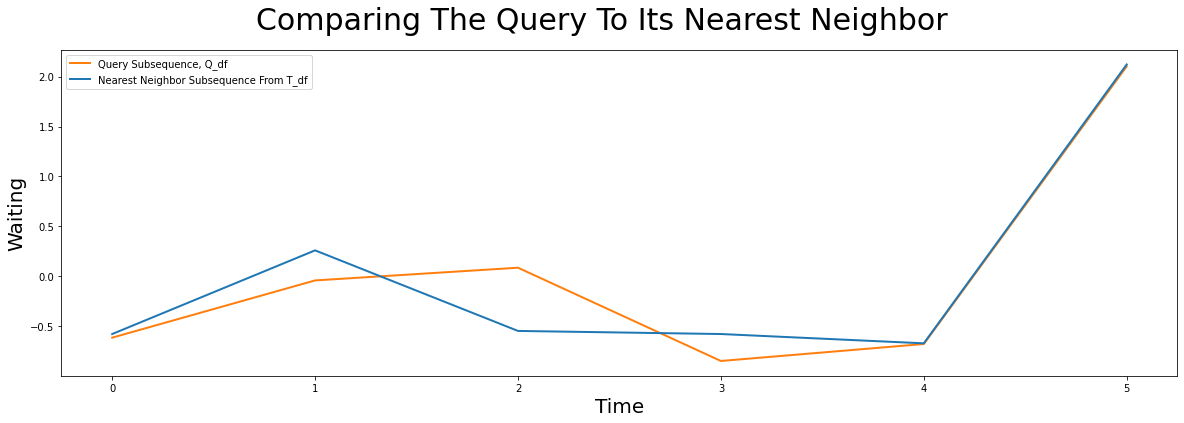

In [261]:
plt.suptitle('Comparing The Query To Its Nearest Neighbor', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Waiting', fontsize='20')
plt.plot(Q_z_norm, lw=2, color="C1", label="Query Subsequence, Q_df")
plt.plot(nn_z_norm, lw=2, label="Nearest Neighbor Subsequence From T_df")
rect = Rectangle((12, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
plt.legend()
plt.show()

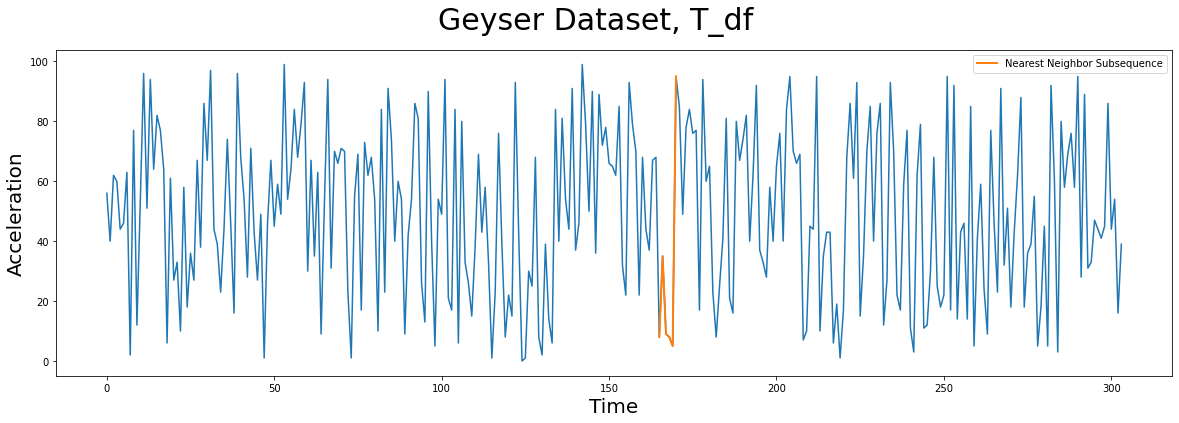

In [260]:
plt.suptitle('Geyser Dataset, T_df', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Acceleration', fontsize='20')
plt.plot(T_df)
ax = plt.gca()
plt.plot(range(idx, idx+len(Q_df)), T_df.values[idx:idx+len(Q_df)], lw=2, label="Nearest Neighbor Subsequence")
plt.legend()
plt.show()

### Matrix Profile on Data Stream

## WIP

In [ ]:
"""%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation
from IPython.display import HTML
import os

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
steam_df.head()"""

In [ ]:
"""T_full = steam_df['steam flow'].values
T_stream = T_full[:2000]
stream = stumpy.stumpi(T_stream, m, egress=False)  # Don't egress/remove the oldest data point when streaming"""

In [ ]:
""""windows = [(stream.P_, T_stream)]
P_max = -1
for i in range(2000, len(T_full)):
    t = T_full[i]
    stream.update(t)

    if i % 50 == 0:
        windows.append((stream.P_, T_full[:i+1]))
        if stream.P_.max() > P_max:
            P_max = stream.P_.max()""""